## Exploratory Data Analysis

This notebook contains an EDA on the connectivity_events dataset to understand its main characteristics.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aux_balena as aux
import importlib
from tqdm import tqdm
from datetime import datetime, timedelta
%matplotlib inline

In [3]:
dflog = aux.read_base_log()

Mem. usage decreased to 142.03 Mb (51.5% reduction)
Log read in 9.5 s
Converting to timestamp field:  timestamp
Done!


In [4]:
dflog.head()

timestamp  device_id  user_id  server_id  connected
0 2015-05-31 14:30:00        100        4          2       True
1 2015-05-31 14:30:00        101        1          2       True
2 2015-05-31 14:30:00        102        1          2       True
3 2015-05-31 14:30:00        103       26          2       True
4 2015-05-31 14:30:00        104        1          2       True

In [5]:
dflog.shape

(9308207, 5)

In [6]:
dflog.describe()

device_id       user_id     server_id
count  9.308207e+06  9.308207e+06  9.308207e+06
mean   2.196503e+04  1.449126e+03  1.952075e+01
std    1.249662e+04  1.212057e+03  8.772805e+00
min    1.000000e+00  1.000000e+00  2.000000e+00
25%    9.529000e+03  1.680000e+02  1.300000e+01
50%    2.068500e+04  1.325000e+03  2.000000e+01
75%    3.004600e+04  2.359000e+03  2.700000e+01
max    5.630200e+04  5.455000e+03  3.300000e+01

In [7]:
aux.null_data_stats(dflog)

total  percentage
connected      0         0.0
server_id      0         0.0
user_id        0         0.0
device_id      0         0.0
timestamp      0         0.0

The dataset does not have any missing values

In [10]:
dflog[['device_id','user_id','server_id']].apply(aux.nunique)

device_id    56302
user_id       5455
server_id       29
dtype: int64

Device_id and user_id have progressive id's from 1 to their max number because the count of unique values matches their max value.

Server_id ranges from 2 to 33 (see output of describe() query) but only 29 different values are included in the connectivity events.

In [11]:
np.unique(dflog.server_id)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33], dtype=int8)

Servers 22,23 and 24 do not appear among the connectivity events

## Users vs. devices relationships

How many devices do users have?

In [12]:
user_device_count = dflog.groupby('user_id')['device_id'].apply(aux.nunique).to_frame()
user_device_count.columns=['device_count']

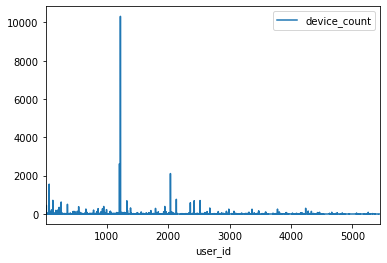

In [15]:
user_device_count.plot();

The count of devices per users spans several orders of magnitude, with most users having few devices and a few users having many devices.

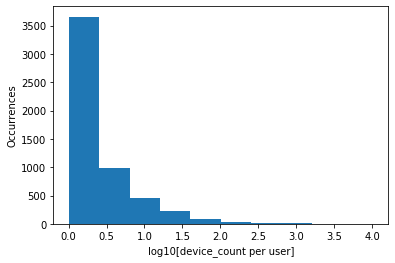

In [16]:
plt.hist(np.log10(user_device_count.device_count));
plt.xlabel('log10[device_count per user]');
plt.ylabel('Occurrences');

In [19]:
user_device_count.loc[user_device_count.idxmax()]

device_count
user_id              
1220            10321

User 1220 is the one with most devices

### Device-user database

A database is created reporting for each device its user_id. This will be useful in future analysis

In [63]:
device_user_db = dflog.groupby('device_id')['user_id'].apply(lambda x: np.unique(x)).to_frame()

In [64]:
device_user_db.rename(columns={'user_id': 'user_list'},inplace=True)

In [65]:
device_user_db['n_user'] = device_user_db.user_list.apply(len)

In [66]:
device_user_db.head()

user_list  n_user
device_id                  
1               [1]       1
2               [2]       1
3               [1]       1
4               [1]       1
5               [1]       1

Check if any device has more than 1 user:

In [67]:
multi_user = device_user_db[device_user_db.n_user>1]
multi_user

user_list  n_user
device_id                      
1037         [177, 319]       2
1177         [177, 319]       2
1409         [177, 319]       2
1410         [177, 319]       2
2105         [177, 319]       2
31471      [3209, 4159]       2
31473      [3209, 4159]       2
33497      [3209, 4159]       2
33498      [3209, 4159]       2
37135      [3209, 4159]       2
38847      [3209, 4159]       2
39119      [3209, 4159]       2
40907      [1869, 4159]       2

In [68]:
print('Number of devices with more than one user_id:', len(multi_user))

Number of devices with more than one user_id: 13


In [48]:
k=0
dsub = dflog[dflog.device_id==multi_user.index.values[k]]
len(dsub)
plt.step(dsub.timestamp, dsub.user_id,marker='.',where='post');

This finding makes little sense, each device should be associated to a single user. Why more than one then? The issue should be investigated in more detail.

For this study we will associate each device to the lowest user_id. Overall results should not change significantly as only 13 devices have this issue (0.2 % of all devices)

In [69]:
device_user_db['user_id'] = device_user_db.user_list.apply(lambda x: x[0])

In [70]:
device_user_db.head()

user_list  n_user  user_id
device_id                           
1               [1]       1        1
2               [2]       1        2
3               [1]       1        1
4               [1]       1        1
5               [1]       1        1

Export to csv file

In [62]:
device_user_db['user_id'].to_frame().to_csv('Device_user_database.csv',index = True)

### Number of log datapoints for each device

How many events are recorded for each device?

In [17]:
# counts the number of connectivity events for each device
device_datapoint_count = dflog.groupby('device_id')['connected'].count().to_frame()
device_datapoint_count.columns=['datapoints']

In [18]:
device_datapoint_count.describe()

datapoints
count  5.630200e+04
mean   1.653264e+02
std    1.033952e+04
min    1.000000e+00
25%    2.000000e+00
50%    4.000000e+00
75%    2.400000e+01
max    2.385613e+06

In [20]:
device_datapoint_count.plot();
plt.ylabel('# of datapoints');

In [21]:
plt.hist(np.log10(device_datapoint_count.datapoints));
plt.yscale('log');
plt.xlabel('log10[datapoints]');
plt.ylabel('# of devices');
plt.grid();

In [22]:
device_datapoint_count.loc[device_datapoint_count.idxmax()]

datapoints
device_id            
9529          2385613

Device 9529 has most connectivity events

In [86]:
d9529 = dflog.loc[dflog.device_id==9529]
d9529 = d9529.copy()
d9529.sort_values(by='timestamp',inplace=True)
d9529.reset_index(inplace=True)

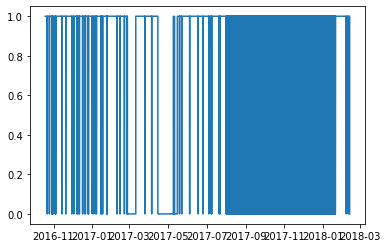

In [87]:
plt.step(d9529.timestamp, d9529.connected,where='post');

## Devices vs. servers

How many servers does each device connect to?

In [150]:
device_server_count = dflog.groupby('device_id')['server_id'].apply(lambda x: len(np.unique(x)))

In [151]:
device_server_count.plot();

In [152]:
device_server_count.hist(bins = np.arange(30));